# Data Augmentation in Tensorflow

- This tutorial demonstrates manual image manipulations and augmentation using tf.image.


In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow_datasets as tfds

In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import PIL

# Some examples of using tf.image

24576/17858 [=========================================] - 0s 0us/step


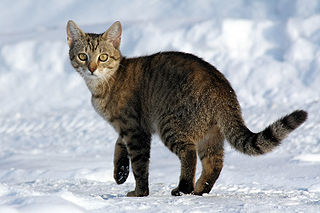

In [5]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [0]:
# Reading image in tensor format
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels=3) 

In [0]:
# Function to vizualize and compare the two images
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(augmented)


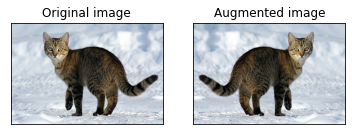

In [8]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

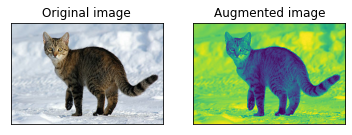

In [9]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))

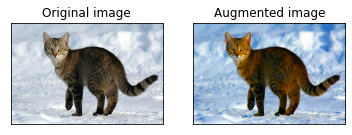

In [10]:
saturated = tf.image.adjust_saturation(image, saturation_factor=3)
visualize(image, saturated)

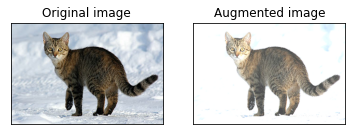

In [11]:
bright = tf.image.adjust_brightness(image, delta=0.3)
visualize(image, bright)

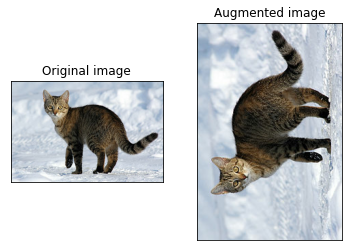

In [12]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

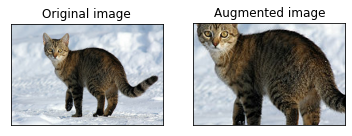

In [13]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
visualize(image, cropped)

# Using the augemented images to train a DL model

In [14]:
dataset, info = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
num_train_examples = info.splits['train'].num_examples

In [16]:
print(num_train_examples)

60000


Write a function to augment the images. Map it over the the dataset. This returns a dataset that augments the data on the fly.

In [0]:
def convert(image, label):
    # this will typecast and normalize the image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [0]:
def augment(image, label):
    image, label = convert(image, label)
    # image = tf.image.convert_image_dtype()
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)  #  Adds a padding of 6 pixels
    image = tf.image.random_crop(image, size=(28, 28, 1))    # converts back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5)

    return image, label
  

In [0]:
BATCH_SIZE = 64
NUM_EXAMPLES = 60000

In [0]:
augmented_train_batches = (
    train_dataset.take(NUM_EXAMPLES).cache().shuffle(NUM_EXAMPLES // 4).map(augment).batch(BATCH_SIZE).prefetch(1)
)

In [29]:
print(augmented_train_batches)

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [0]:
validation_batches = (
    test_dataset
    .map(convert)
    .batch(2*BATCH_SIZE)
)


In [0]:
def make_model():
    model = tf.keras.Sequential([
                                 layers.Conv2D(32, (3,3), padding='same', input_shape=(28, 28, 1), activation='relu'),
                                 layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                                 layers.Conv2D(128, (3,3), padding='same', activation='relu'),
                                 layers.Flatten(),
                                 layers.Dense(128, activation='relu'),
                                 layers.Dense(128, activation='relu'),
                                 layers.Dense(10, activation='softmax')
    ])

    return model

In [0]:
model = make_model()

In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [34]:
hist = model.fit(augmented_train_batches, validation_data=validation_batches, epochs=10)

Epoch 1/10
938/938 [==============================] - 35s 37ms/step - loss: 1.6248 - acc: 0.8361 - val_loss: 1.5075 - val_acc: 0.9538
Epoch 2/10
938/938 [==============================] - 29s 31ms/step - loss: 1.5276 - acc: 0.9332 - val_loss: 1.5058 - val_acc: 0.9545
Epoch 3/10
938/938 [==============================] - 29s 31ms/step - loss: 1.5168 - acc: 0.9442 - val_loss: 1.5015 - val_acc: 0.9594
Epoch 4/10
938/938 [==============================] - 29s 31ms/step - loss: 1.5182 - acc: 0.9428 - val_loss: 1.4971 - val_acc: 0.9648
Epoch 5/10
938/938 [==============================] - 29s 31ms/step - loss: 1.5219 - acc: 0.9390 - val_loss: 1.5126 - val_acc: 0.9479
Epoch 6/10
938/938 [==============================] - 29s 31ms/step - loss: 1.5274 - acc: 0.9337 - val_loss: 1.5219 - val_acc: 0.9391
Epoch 7/10
938/938 [==============================] - 29s 31ms/step - loss: 1.5341 - acc: 0.9270 - val_loss: 1.5201 - val_acc: 0.9410
Epoch 8/10
938/938 [==============================] - 29s 31ms